# CO₂ Emissions: OLS Regression & Model Diagnostics


**Ordinary Least Squares (OLS)** is a foundational regression technique used to estimate the relationship between one or more independent variables (features) and a dependent variable (target). It works by finding the line (or hyperplane) that minimizes the sum of the squared differences between the observed values and the model’s predicted values. OLS operates under the assumption that the dependent variable has a linear relationship with the independent variables.

---

### Define the Problem
Can CO2 be accurately predicted knowing the Population, Biomass, Geothermal, Solar, Wind, Hydro, Coal, Petroleum, Gas, Nuclear, Other energy sources from the Energy Generation by State and Technology (2009) dataset? 

**The dataset:** Provides annual energy generation/ production for all states by fuel source (e.g. coal, gas, solar, wind) in 2009, reported in MWh. Also includes facility-level data (directly from EIA Form 923). National Renewable Energy Laboratory. (2014). Energy Generation by State and Technology (2009) [data set]. Retrieved from https://data.openei.org/submissions/249.

**Features:**
- Population
- Biomass (MWh)
- Geothermal (MWh)
- Solar (MWh)
- Wind (MWh)
- Hydro (MWh)
- Coal (MWh)
- Petroleum (MWh)
- Gas (MWh)
- Nuclear (MWh)
- Other (MWh)

**Target:**
- Carbon Dioxide emissions (million metric tons)

---

### Summary of Findings
Using a state-level dataset of CO₂ emissions and energy-generation variables, I developed a multiple linear regression model to explain log-transformed CO₂ emissions across U.S. states. After preprocessing, scaling, checking linearity, and performing stepwise feature selection, the final model retained **population**, **Coal**, and **Wind** as predictors.

On the 80% training split, the model demonstrated strong explanatory power with **R² = 0.899**, indicating that nearly 90% of emissions variability is captured by the selected features.

### Model Assumptions (Consolidated)
A full diagnostic review confirmed that the core regression assumptions were reasonably satisfied:

- **Normality:** Residuals were approximately normal with only mild right-skew.  
- **Linearity:** X–Y plots and residual-vs-fitted plots showed no strong curvature.  
- **Homoscedasticity:** Breusch–Pagan test (p ≈ 0.068) indicated no significant heteroscedasticity.  
- **Autocorrelation:** Durbin–Watson = **2.41**, showing no meaningful autocorrelation.  
- **Multicollinearity:** VIF values were low — population (**1.455**), Coal (**1.332**), Wind (**1.129**).

### Generalization Performance
On the 20% held-out test set, the model maintained stable predictive accuracy:

- **R²:** 0.899 → **0.705**  
- **RMSE:** 0.331 → **0.466**  
- **MAE:** 0.243 → **0.413**

These differences reflect normal generalization loss and indicate that the model is not overfitting. Predictions remained consistent, with larger errors mainly occurring in high-emission states where small log-scale differences translate into larger absolute differences.

### Conclusion
This regression model is **explanatory, stable, and interpretable**. Population and Coal generation are the strongest contributors to increased emissions, while Wind generation shows a modest mitigating effect. The model generalizes well and provides a strong baseline for emissions modeling, suitable for future enhancements such as interaction terms, nonlinear transformations, or the addition of socioeconomic and regional predictors.

---

**Pipeline**
1) Load & inspect data  
2) Exploratory data analysis (distributions, outliers, and or transformations)  
2.1) Log-transform skewed features    
2.2) Check linear relationship: raw vs log(X) against log(CO₂)  
3) Train/Test split, log transform & scale (sklearn) 
4) Fit the OLS linear regression model (training data only) + evaluation  
5) Check model assumptions (training data only)  
5.1) Linearity & Homoscedasticity - scatter plot of residuals vs fitted values  
5.2) Normality of residuals - histogram  
5.3) Autocorrelation check Durbin–Watson  
5.4) Check for multicollinearity (VIF)  
6) Evaluation on test data
7) Interpretation & recommendations


### Import Libraries

Working in Python 3.9.12 and the Package versions are:
- pandas: 1.5.3
- numpy: 1.23.5
- statsmodels: 0.14.2
- matplotlib: 3.9.2
- seaborn: 0.13.2
- scikit-learn: 1.2.2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore", message="Glyph 8322")  # avoid CO₂ Arial glyph warning
plt.rcParams["figure.dpi"] = 120


## 1) Load & Inspect Data

In [2]:
# Display big numbers with commas instead of scientific notation
pd.options.display.float_format = '{:,.0f}'.format

raw_co2_data = pd.read_csv('energy by state and sector.csv')
co2_data = raw_co2_data.copy()


# Keep relevant columns
cleaned_co2_data = co2_data[[
    'population', 'Carbon Dioxide emissions (million metric tons)',
    'Biomass', 'Geothermal', 'Solar', 'Wind', 'Hydro',
    'Coal', 'Petroleum', 'Gas', 'Nuclear', 'Other'
]].copy()

display(cleaned_co2_data.head())
display(cleaned_co2_data.describe(include='all'))
cleaned_co2_data.info()

,population,Carbon Dioxide emissions (million metric tons),Biomass,Geothermal,Solar,Wind,Hydro,Coal,Petroleum,Gas,Nuclear,Other
0,4779736,120,"3,291,196",0,0,0,"11,753,493","55,659,872","163,054","32,369,863",39716204,"7,137"
1,710231,38,"4,255",0,0,"3,062","1,204,550","566,822","1,191,884","3,571,101",0,0
2,6392017,93,"159,646",0,"13,759","9,555","6,348,463","39,783,826","67,337","34,852,150",30661851,534
3,2915918,62,"1,478,310",0,0,0,"4,195,168","25,075,250","87,674","11,368,417",15169966,"24,019"
4,37253956,372,"6,062,630","13,022,836","611,763","5,764,637","27,707,085","1,948,279","1,638,019","115,749,546",31734676,"440,323"


,population,Carbon Dioxide emissions (million metric tons),Biomass,Geothermal,Solar,Wind,Hydro,Coal,Petroleum,Gas,Nuclear,Other
count,51,51,51,51,51,51,51,51,51,51,51,51
mean,"6,053,834",105,"1,065,443","297,908","15,843","1,387,790","5,335,901","34,597,755","761,306","18,256,390","15,622,578","217,215"
std,"6,823,984",99,"1,284,526","1,831,934","87,726","3,050,631","12,057,598","34,413,517","1,716,192","34,443,036","20,487,102","421,015"
min,"563,626",3,0,0,0,0,0,0,124,0,0,0
25%,"1,696,962",40,"80,294",0,0,0,"571,692","4,271,175","47,676","1,618,324",0,661
50%,"4,339,367",82,"599,703",0,0,"213,224","1,576,275","29,084,699","170,674","6,424,511","8,816,673","33,633"
75%,"6,636,084",132,"1,510,963",0,0,"1,878,767","3,978,597","47,904,576","687,557","20,669,295","27,587,126","340,884"
max,"37,253,956",550,"6,062,630","13,022,836","611,763","19,367,239","73,932,815","139,106,597","8,962,843","191,652,532","94,050,482","2,576,795"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 12 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   population                                      51 non-null     int64  
 1   Carbon Dioxide emissions (million metric tons)  51 non-null     int64  
 2   Biomass                                         51 non-null     float64
 3   Geothermal                                      51 non-null     float64
 4   Solar                                           51 non-null     float64
 5   Wind                                            51 non-null     float64
 6   Hydro                                           51 non-null     float64
 7   Coal                                            51 non-null     float64
 8   Petroleum                                       51 non-null     float64
 9   Gas                                          

## 2) Exploratory Data Analysis

The focus is on population, CO₂ emissions, and energy source variables.  
Histograms (PDFs) and a condensed boxplot help spot skewness and outliers.

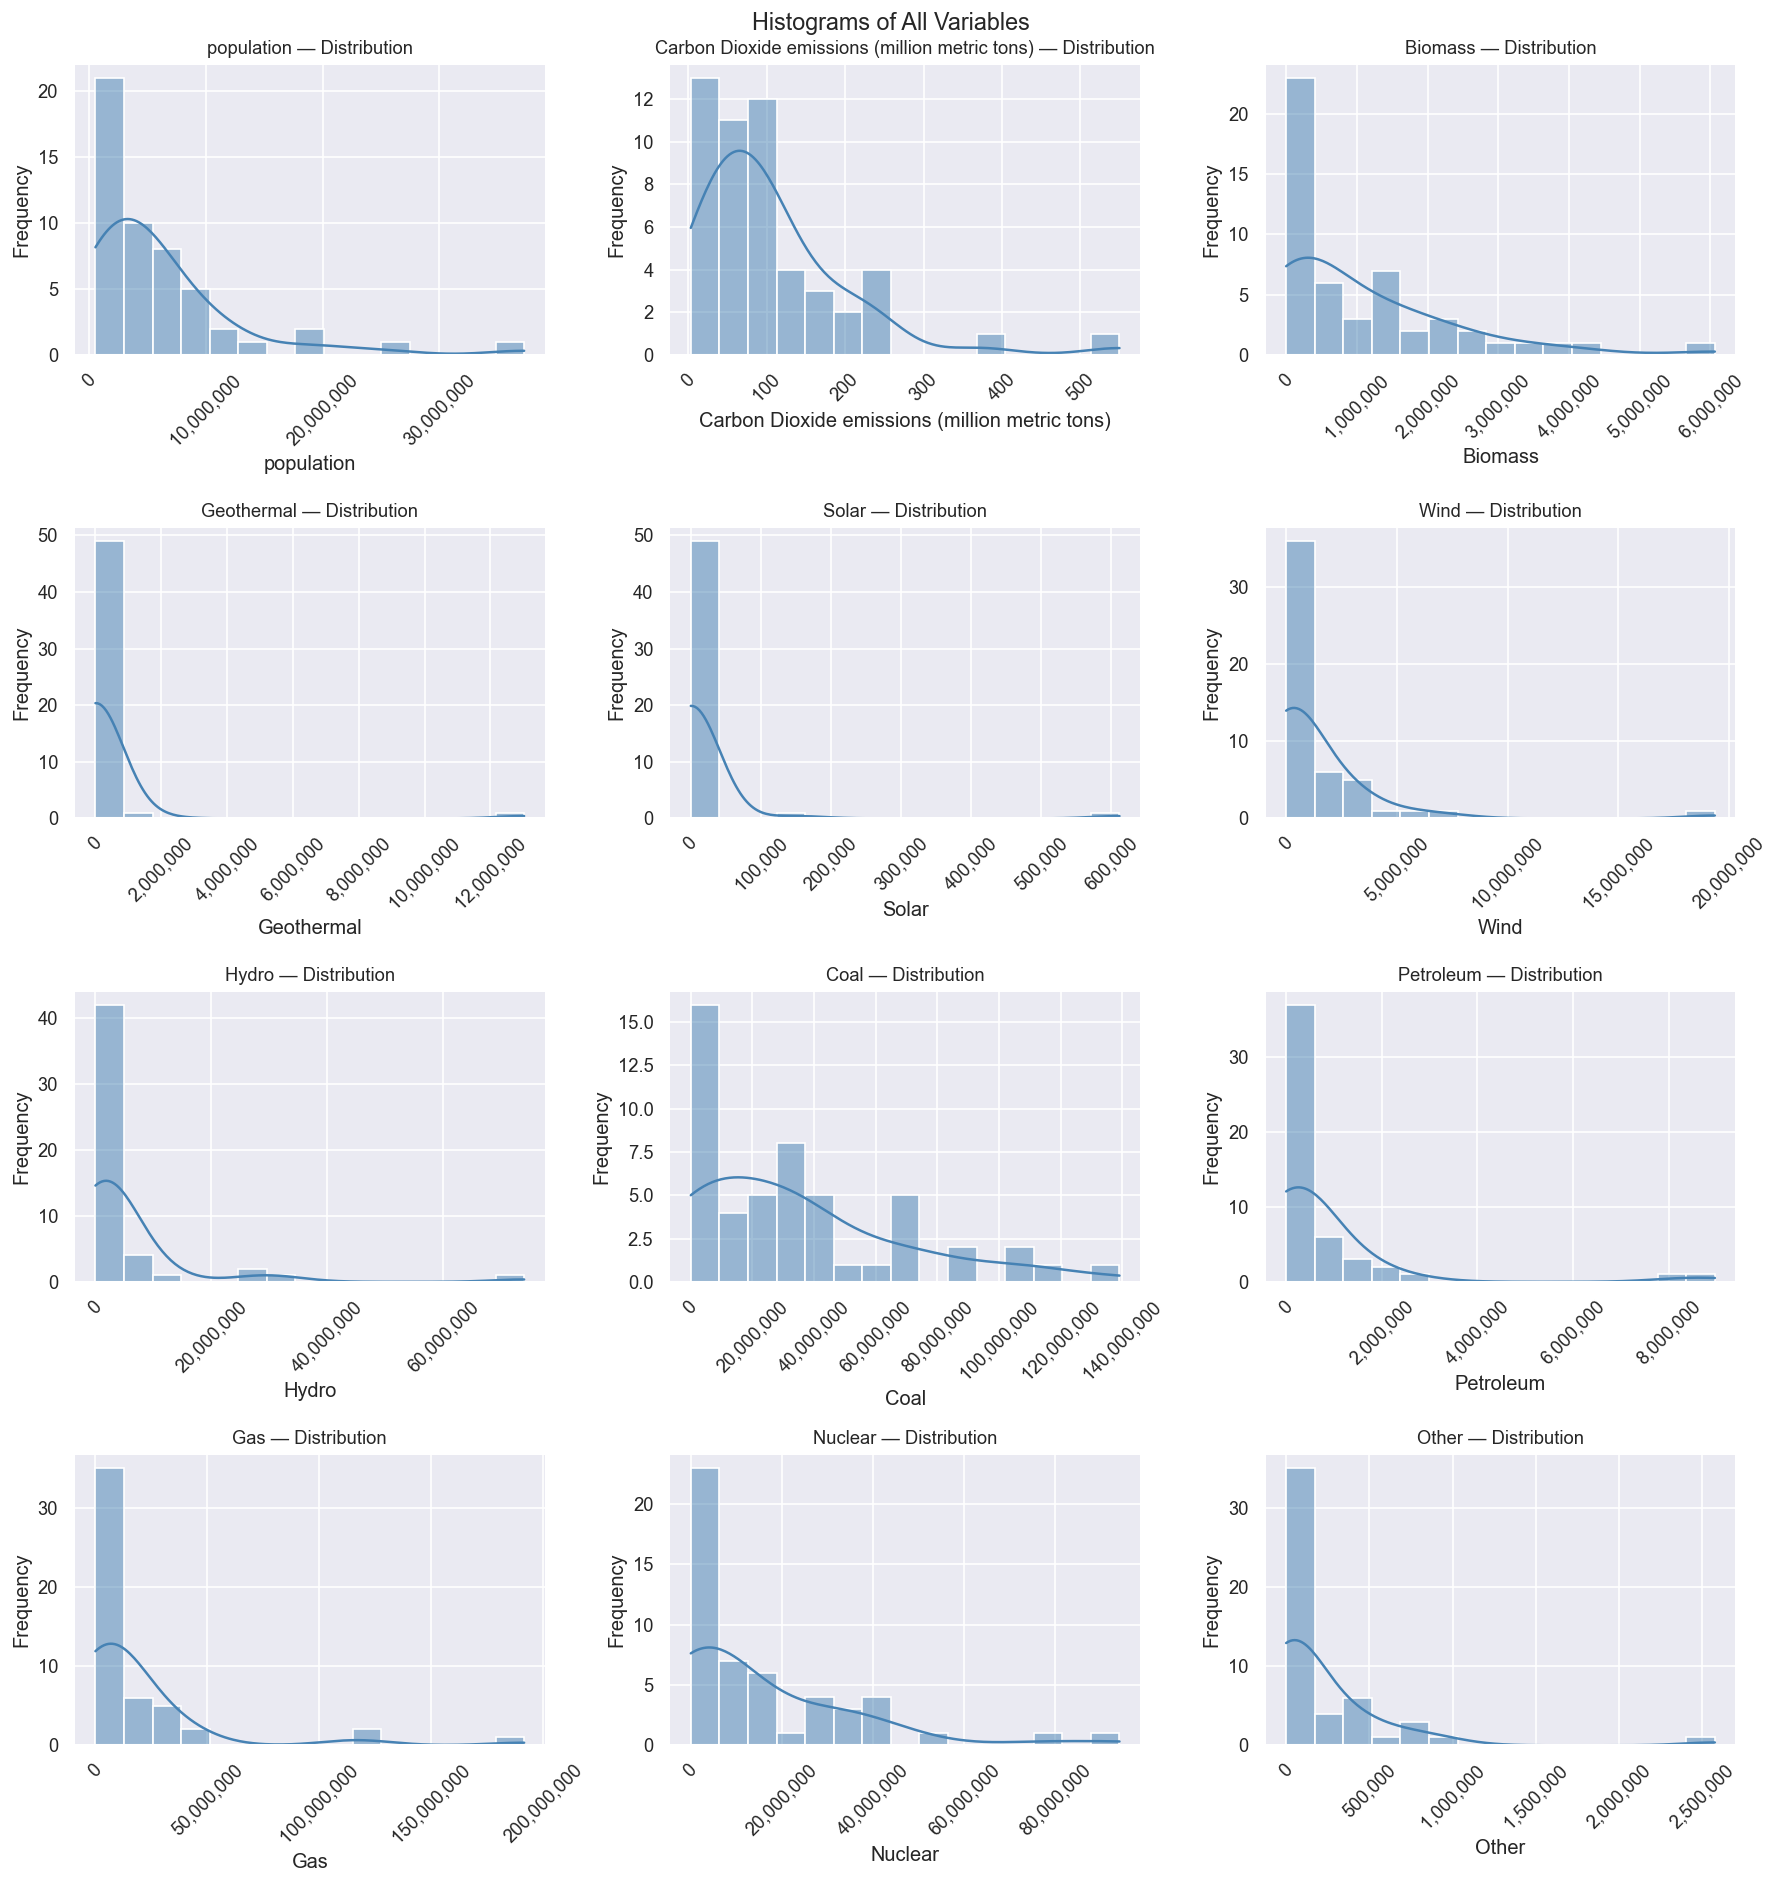

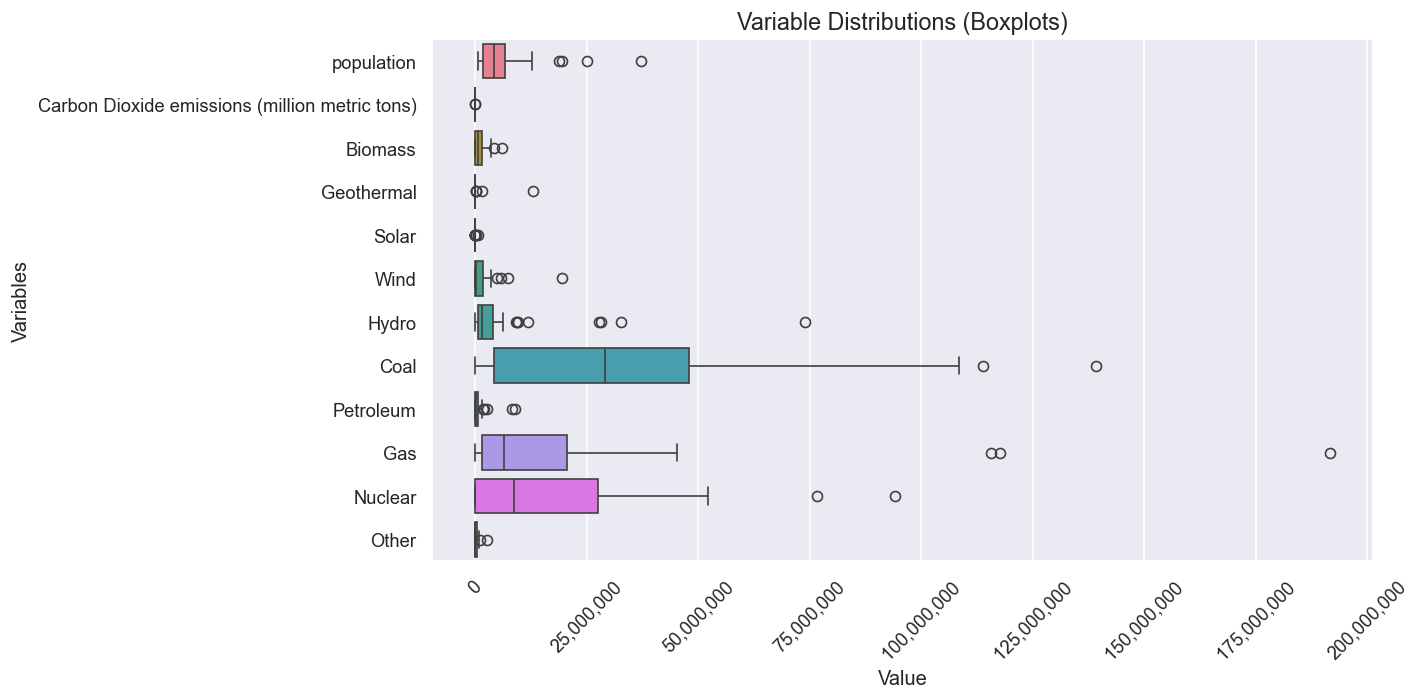

In [3]:
import matplotlib.ticker as mtick

# Formatter for comma-separated large numbers
comma_fmt = mtick.FuncFormatter(lambda x, pos: f'{int(x):,}')

numeric_cols = cleaned_co2_data.select_dtypes(include='number').columns

# Histograms (all numeric)
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(cleaned_co2_data[col], bins=15, kde=True, color='steelblue', ax=axes[i])
    axes[i].set_title(f'{col} — Distribution', fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

    # Apply comma formatting to x-axis
    axes[i].xaxis.set_major_formatter(comma_fmt)

    # Rotate labels for readability
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Histograms of All Variables', fontsize=14)
plt.tight_layout()
plt.show()

# Condensed boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=cleaned_co2_data[numeric_cols], orient='h')
plt.title('Variable Distributions (Boxplots)', fontsize=14)
plt.xlabel('Value')
plt.ylabel('Variables')

# Apply comma formatting to x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(comma_fmt)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 2.1) Log-Transform Skewed Features

Strong right skew was observed for **population, CO₂, Coal, Petroleum, Gas, Nuclear**.  
Apply `log1p` (safe for zeros) and inspect the transformed PDFs.


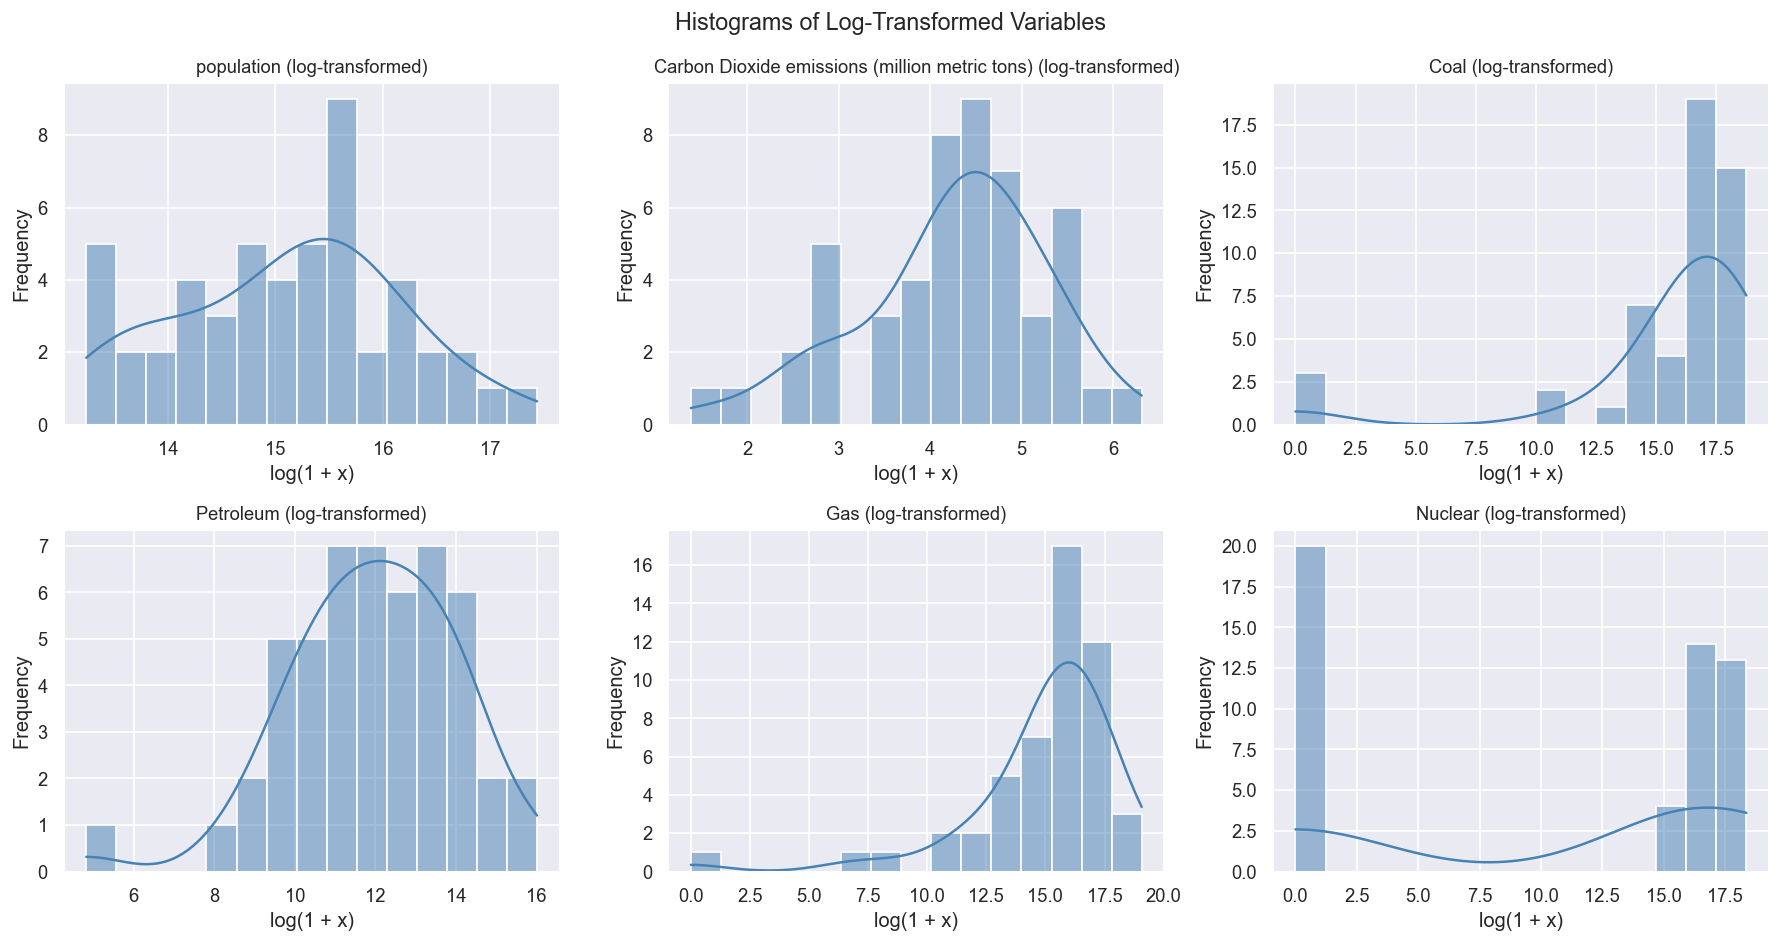

In [4]:
cols_to_log = [
    'population',
    'Carbon Dioxide emissions (million metric tons)',
    'Coal', 'Petroleum', 'Gas', 'Nuclear'
]

# Apply the log transformation safely using .loc[row_indexer, col_indexer]
for col in cols_to_log:
    cleaned_co2_data.loc[:, f'{col}_log'] = np.log1p(cleaned_co2_data.loc[:, col])

# Identify all log-transformed columns    
log_cols = [c for c in cleaned_co2_data.columns if c.endswith('_log')]

# Histograms (log-transformed only) (2 rows x 3 columns)
n_cols = 3
n_rows = int(len(log_cols) / n_cols) + (len(log_cols) % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

# Plot histograms for each log-transformed variable
for i, col in enumerate(log_cols):
    sns.histplot(cleaned_co2_data[col], bins=15, kde=True, color='steelblue', ax=axes[i])
    axes[i].set_title(col.replace('_log', ' (log-transformed)'), fontsize=11)
    axes[i].set_xlabel('log(1 + x)')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots (in case grid is larger than needed)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Add overall title and adjust layout
fig.suptitle('Histograms of Log-Transformed Variables', fontsize=14)
plt.tight_layout()
plt.show()


## 2.2) Check Linear Relationship: Raw vs log(X) against log(CO₂)

Visualize **raw X vs log(CO₂)** and **log(X) vs log(CO₂)** with trendlines and Pearson’s *r*.
Use the version with the stronger linear signal (higher |r|) and better visual linearity.


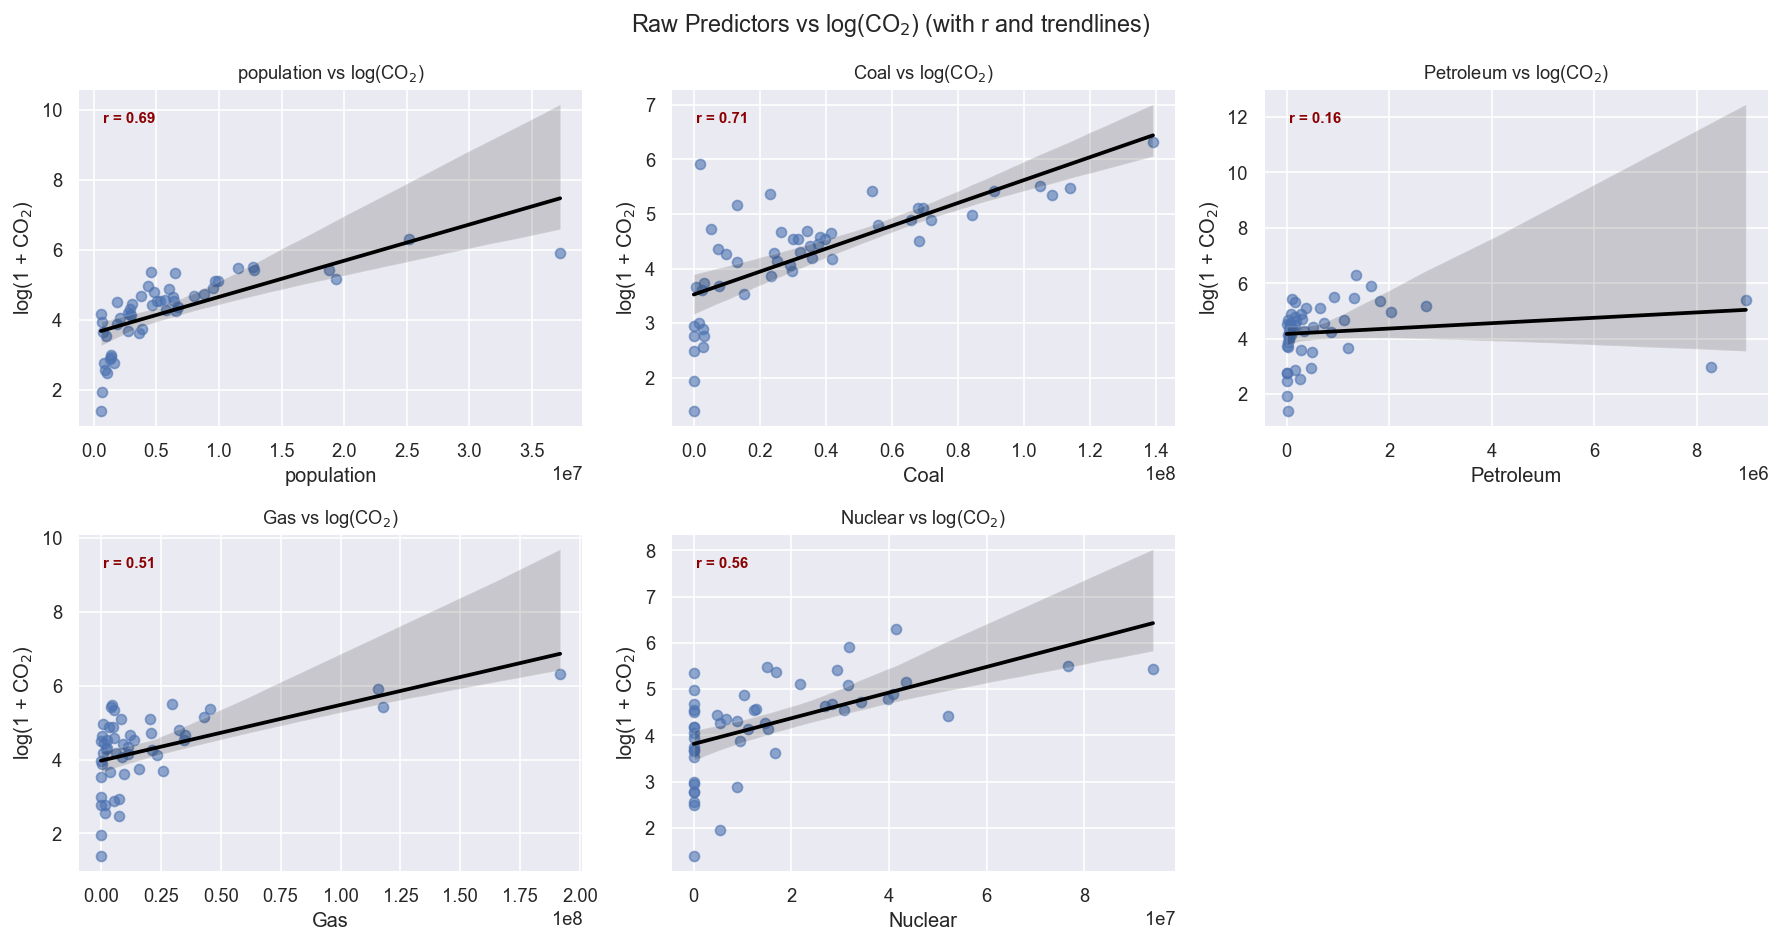

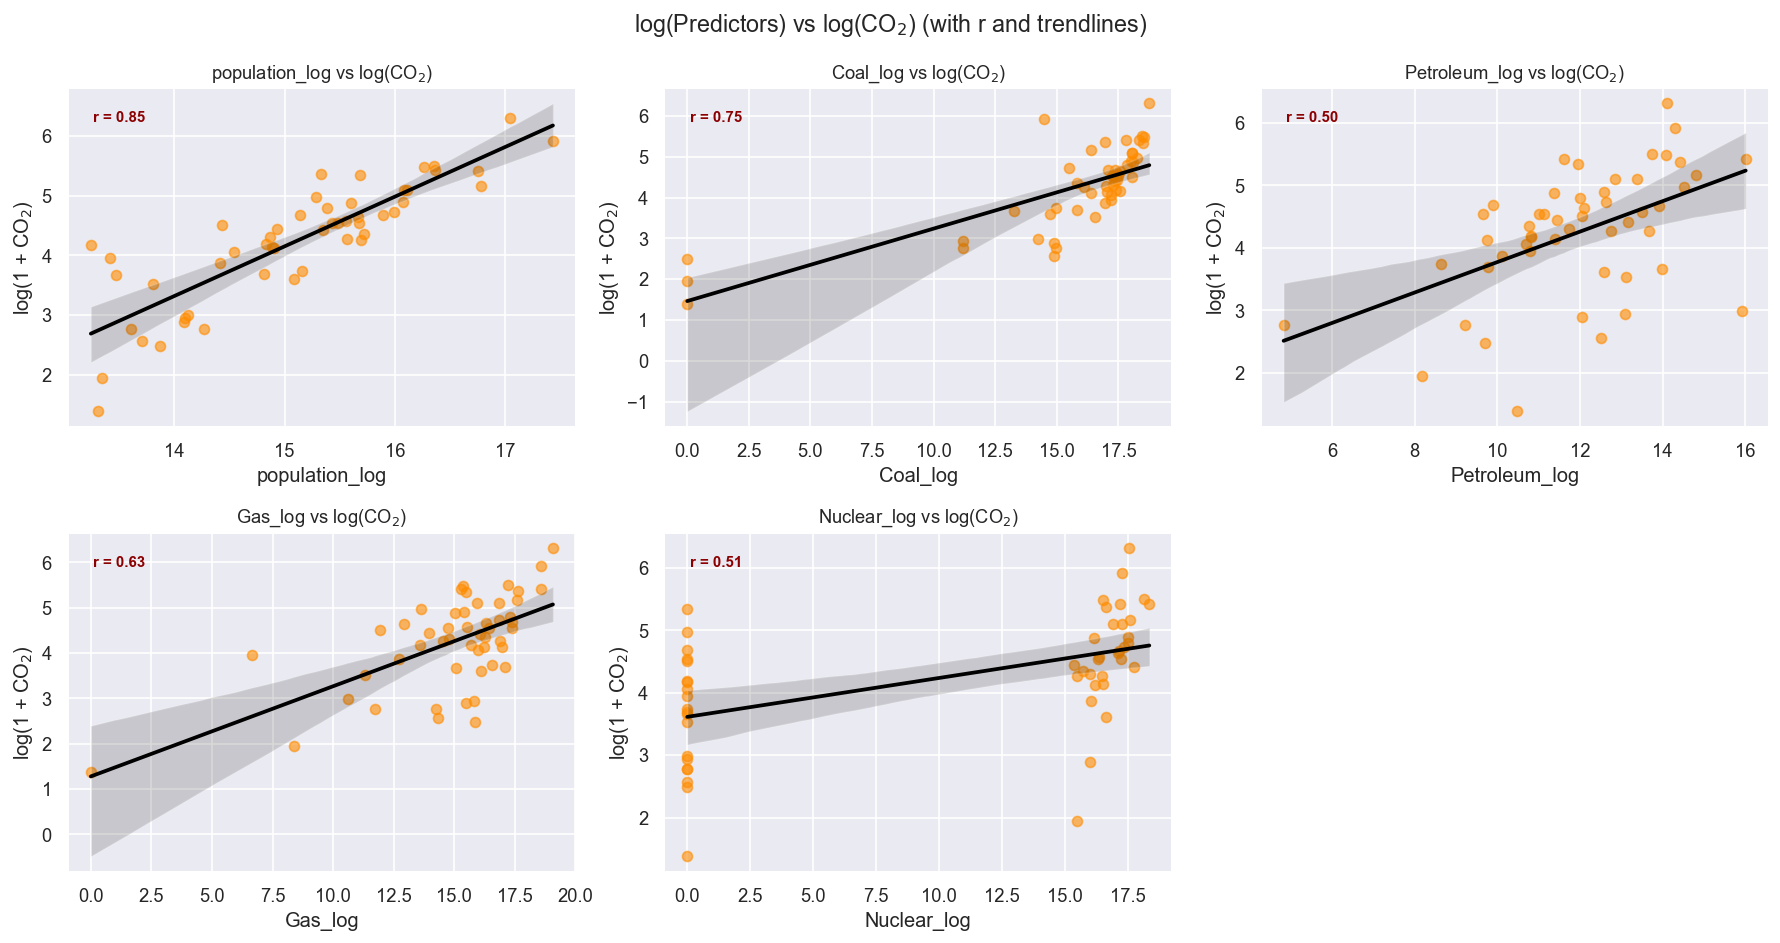

In [5]:
# Define variables
y_col = 'Carbon Dioxide emissions (million metric tons)'
y_log = f'{y_col}_log'

x_raw = ['population', 'Coal', 'Petroleum', 'Gas', 'Nuclear']
x_log = [f'{c}_log' for c in x_raw]

# Function to add correlation annotation
def annotate_corr(ax, x, y):
    r, _ = pearsonr(x, y)
    ax.text(0.05, 0.9, f"r = {r:.2f}", transform=ax.transAxes,
            fontsize=9, color='darkred', fontweight='bold')

# Raw X vs log(CO2)
n_cols = 3
n_rows = int(np.ceil(len(x_raw) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(x_raw):
    sns.regplot(
        x=cleaned_co2_data[col],
        y=cleaned_co2_data[y_log],
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'black'},
        ax=axes[i]
    )
    annotate_corr(axes[i], cleaned_co2_data[col], cleaned_co2_data[y_log])
    axes[i].set_title(f'{col} vs log(CO$_2$)', fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('log(1 + CO$_2$)')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Raw Predictors vs log(CO$_2$) (with r and trendlines)', fontsize=14)
plt.tight_layout()
plt.show()

# log(X) vs log(CO2)
n_cols = 3
n_rows = int(np.ceil(len(x_log) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(x_log):
    sns.regplot(x=cleaned_co2_data[col], y=cleaned_co2_data[y_log],
                scatter_kws={'alpha': 0.6, 'color': 'darkorange'},
                line_kws={'color': 'black'}, ax=axes[i])
    annotate_corr(axes[i], cleaned_co2_data[col], cleaned_co2_data[y_log])
    axes[i].set_title(f'{col} vs log(CO$_2$)', fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('log(1 + CO$_2$)')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('log(Predictors) vs log(CO$_2$) (with r and trendlines)', fontsize=14)
plt.tight_layout()
plt.show()



r measures linear strength between variables.

It ranges from -1 to +1:

- r ≈ 0 → no linear relationship
- r ≈ 0.5 → moderate linear relationship
- r ≥ 0.7 → strong linear relationship

Based on the finding, the model should have the log of population, coal, petroleum, gas, and CO2 while all other variables can remain as is.

## 3) Train/Test Split with Log Transform & Scale (sklearn) 

In [6]:
# 1. Define log-transformed features
log_features = ['population','Coal','Petroleum','Gas']
y_col = 'Carbon Dioxide emissions (million metric tons)'

# 2. Separate X and y (before split)
X = cleaned_co2_data[['population','Biomass','Geothermal','Solar','Wind',
          'Hydro','Coal','Petroleum','Gas','Nuclear','Other']]
y = cleaned_co2_data[y_col]

# 3. Train/Test split (no log yet)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=365
)

# 4. Log-transform ONLY selected (log_features) columns (after split)
X_train_log = X_train.copy()
X_test_log  = X_test.copy()

for col in log_features:
    X_train_log[col] = np.log1p(X_train[col])
    X_test_log[col]  = np.log1p(X_test[col])

# Log-transform the target
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# Scale X (TRAINING ONLY FIT, then transform both)
scaler = StandardScaler()
scaler.fit(X_train_log)  # learns mean/std from TRAINING data only

X_train_scaled_array = scaler.transform(X_train_log)
X_test_scaled_array  = scaler.transform(X_test_log)

# Wrap scaled features back into DataFrames to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled_array,
                              columns=X_train_log.columns,
                              index=X_train_log.index)

X_test_scaled = pd.DataFrame(X_test_scaled_array,
                             columns=X_test_log.columns,
                             index=X_test_log.index)



Features & Target explained:
- Features: 
    - X_train_scaled: scaled training data with log of population, Coal, Petroleum, Gas & raw of Biomass, Geothermal, Solar, Wind, Hydro, Nuclear, and Other.
    - X_test_scaled: scaled testing data with log of population, Coal, Petroleum, Gas & raw of Biomass, Geothermal, Solar, Wind, Hydro, Nuclear, and Other.
- Target:
    - y_train_log: Log transformed CO2 training data
    - y_test_log: Log transformed CO2 testing data
    

## 4) Fit the OLS Linear Regression Model (training data only) (statsmodels)

In [7]:
X_train_scaled_const = sm.add_constant(X_train_scaled)
model = sm.OLS(y_train_log, X_train_scaled_const).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     Carbon Dioxide emissions (million metric tons)   R-squared:                       0.907
Model:                                                        OLS   Adj. R-squared:                  0.871
Method:                                             Least Squares   F-statistic:                     24.86
Date:                                            Sat, 22 Nov 2025   Prob (F-statistic):           1.43e-11
Time:                                                    12:19:01   Log-Likelihood:                -10.842
No. Observations:                                              40   AIC:                             45.68
Df Residuals:                                                  28   BIC:                             65.95
Df Model:                                                      11                                         
Covariance Type:                                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2793      0.060     71.364      0.000       4.156       4.402
population     0.6579      0.128      5.139      0.000       0.396       0.920
Biomass        0.1026      0.133      0.769      0.449      -0.171       0.376
Geothermal     0.3209      0.544      0.589      0.560      -0.794       1.436
Solar         -0.2750      0.514     -0.535      0.597      -1.328       0.778
Wind           0.1200      0.067      1.796      0.083      -0.017       0.257
Hydro         -0.0656      0.132     -0.496      0.624      -0.336       0.205
Coal           0.5242      0.101      5.213      0.000       0.318       0.730
Petroleum     -0.0094      0.090     -0.104      0.918      -0.194       0.175
Gas           -0.1127      0.117     -0.965      0.343      -0.352       0.127
Nuclear       -0.0302      0.086     -0.351      0.728      -0.207       0.146
Other         -0.0467      0.083     -0.561      0.579      -0.217       0.124
==============================================================================
Omnibus:                        6.039   Durbin-Watson:                   2.364
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                4.688
Skew:                           0.691   Prob(JB):                       0.0959
Kurtosis:                       3.949   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Taking a quick glance at the model the R-squared: 0.907, Prob (F-statistic): 1.43e-11 and Durbin-Watson: 2.364: concluding an overall successful model. Diving deeper some of the features are not significant. Conducting a backward and forward stepwise regression will identify the most significant features.

In [8]:
# Conduct a backward stepwise selection

def backward_stepwise(X, y, p_remove=0.05, verbose=True):
    """
    Backward stepwise (backward elimination) based on p-values.
    X: DataFrame of candidate predictors (TRAINING DATA ONLY)
    y: Series or array of target
    p_remove: threshold for removing variables (if p > p_remove)
    """
    selected = list(X.columns)
    iteration = 0

    while True:
        iteration += 1
        X_with_const = sm.add_constant(X[selected])
        model = sm.OLS(y, X_with_const).fit()
        pvalues = model.pvalues.drop('const')

        # Find the worst (max) p-value among predictors
        worst_pval = pvalues.max()
        worst_feature = pvalues.idxmax()

        if verbose:
            print(f"Iteration {iteration}: worst feature = {worst_feature}, p = {worst_pval:.4g}")

        if worst_pval > p_remove:
            # Remove this feature and repeat
            selected.remove(worst_feature)
        else:
            if verbose:
                print("All remaining features are below p_remove. Stopping.")
            break

    # Final model
    X_final = sm.add_constant(X[selected])
    final_model = sm.OLS(y, X_final).fit()

    if verbose:
        print("\nSelected features:", selected)
        print(final_model.summary())

    return selected, final_model


In [9]:
selected_features_back, back_model = backward_stepwise(X_train_scaled, y_train_log, p_remove=0.05)

Iteration 1: worst feature = Petroleum, p = 0.918
Iteration 2: worst feature = Nuclear, p = 0.729
Iteration 3: worst feature = Hydro, p = 0.6205
Iteration 4: worst feature = Other, p = 0.6976
Iteration 5: worst feature = Biomass, p = 0.6178
Iteration 6: worst feature = Solar, p = 0.4765
Iteration 7: worst feature = Geothermal, p = 0.5398
Iteration 8: worst feature = Gas, p = 0.2875
Iteration 9: worst feature = Wind, p = 0.04948
All remaining features are below p_remove. Stopping.

Selected features: ['population', 'Wind', 'Coal']
                                          OLS Regression Results                                          
Dep. Variable:     Carbon Dioxide emissions (million metric tons)   R-squared:                       0.899
Model:                                                        OLS   Adj. R-squared:                  0.890
Method:                                             Least Squares   F-statistic:                     106.6
Date:                               

In [10]:
# Conduct a forward stepwise selection

def forward_stepwise(X, y, p_enter=0.05, verbose=True):
    """
    Forward stepwise selection based on p-values (statsmodels OLS).
    X: DataFrame of candidate predictors (TRAINING DATA ONLY)
    y: Series or array of target (TRAINING DATA ONLY)
    p_enter: max p-value allowed to enter the model
    """
    remaining = list(X.columns)
    selected = []
    current_score = None
    best_new_score = None

    while remaining:
        scores_with_candidates = []

        for candidate in remaining:
            # Build model with selected + this candidate
            cols_to_fit = selected + [candidate]
            X_with_const = sm.add_constant(X[cols_to_fit])
            model = sm.OLS(y, X_with_const).fit()

            # Use p-value of the candidate as entry criterion
            pval = model.pvalues[candidate]
            scores_with_candidates.append((pval, candidate, model))

        # Pick candidate with lowest p-value
        scores_with_candidates.sort(key=lambda x: x[0])
        best_pval, best_candidate, best_model = scores_with_candidates[0]

        if verbose:
            print(f"Best candidate: {best_candidate}, p-value = {best_pval:.4g}")

        # Check if it meets entry criterion
        if best_pval < p_enter:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            best_new_score = best_model.aic  # or BIC/R²_adj if you prefer
            current_score = best_new_score
        else:
            if verbose:
                print("No more variables meet the entry criterion. Stopping.")
            break

    # Final model with selected features
    X_final = sm.add_constant(X[selected])
    final_model = sm.OLS(y, X_final).fit()

    if verbose:
        print("\nSelected features:", selected)
        print(final_model.summary())

    return selected, final_model


In [11]:
selected_features, fwd_model = forward_stepwise(X_train_scaled, y_train_log, p_enter=0.05)

Best candidate: population, p-value = 1.027e-12
Best candidate: Coal, p-value = 3.634e-08
Best candidate: Wind, p-value = 0.04948
Best candidate: Gas, p-value = 0.2875
No more variables meet the entry criterion. Stopping.

Selected features: ['population', 'Coal', 'Wind']
                                          OLS Regression Results                                          
Dep. Variable:     Carbon Dioxide emissions (million metric tons)   R-squared:                       0.899
Model:                                                        OLS   Adj. R-squared:                  0.890
Method:                                             Least Squares   F-statistic:                     106.6
Date:                                            Sat, 22 Nov 2025   Prob (F-statistic):           5.70e-18
Time:                                                    12:19:33   Log-Likelihood:                -12.549
No. Observations:                                              40   AIC:             

Based on the backward and forward stepwise regression analysis, the features to keep are population, coal, and wind.

In [12]:
cols_to_keep = ['population', 'Coal', 'Wind'] 

# modifying training and testing data to contain only the significant features
X_train_new = X_train_scaled[cols_to_keep]
X_test_new  = X_test_scaled[cols_to_keep]

model2 = sm.OLS(y_train_log, sm.add_constant(X_train_new)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     Carbon Dioxide emissions (million metric tons)   R-squared:                       0.899
Model:                                                        OLS   Adj. R-squared:                  0.890
Method:                                             Least Squares   F-statistic:                     106.6
Date:                                            Sat, 22 Nov 2025   Prob (F-statistic):           5.70e-18
Time:                                                    12:19:43   Log-Likelihood:                -12.549
No. Observations:                                              40   AIC:                             33.10
Df Residuals:                                                  36   BIC:                             39.85
Df Model:                                                       3                                         
Covariance Type:                                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2793      0.055     77.539      0.000       4.167       4.391
population     0.6281      0.067      9.434      0.000       0.493       0.763
Coal           0.4572      0.064      7.178      0.000       0.328       0.586
Wind           0.1192      0.059      2.033      0.049       0.000       0.238
==============================================================================
Omnibus:                        3.718   Durbin-Watson:                   2.412
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.501
Skew:                           0.551   Prob(JB):                        0.286
Kurtosis:                       3.536   Cond. No.                         1.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5) Check model assumptions (training data only)

### 5.1) Linearity & Homoscedasticity - Scatter Plots

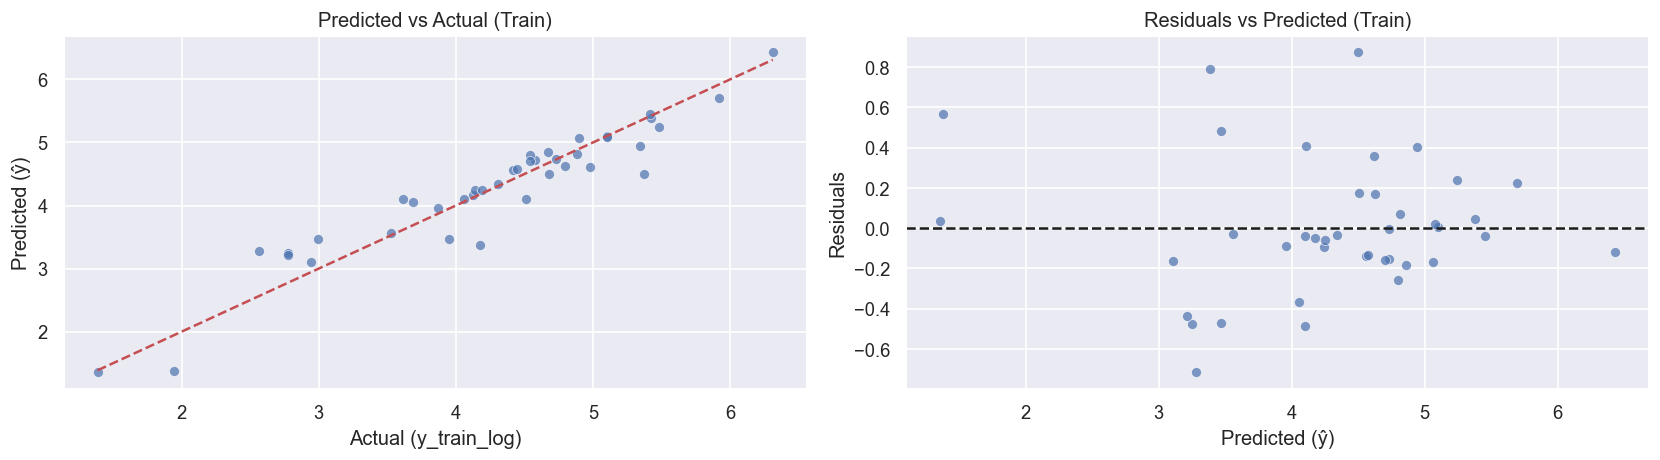

In [13]:
# Initialize and fit model on TRAINING data
reg = LinearRegression()
reg.fit(X_train_new, y_train_log)

# Fit predictions on training data
y_hat_train_log = reg.predict(X_train_new)

# Residual diagnostics (test)
residuals = y_train_log - y_hat_train_log

# Predicted vs Actual (Train)
fig, axes = plt.subplots(1, 2, figsize=(14,4))
sns.scatterplot(x=y_train_log, y=y_hat_train_log, ax=axes[0], alpha=0.7)
axes[0].plot([y_train_log.min(), y_train_log.max()], [y_train_log.min(), y_train_log.max()], 'r--')
axes[0].set_title('Predicted vs Actual (Train)')
axes[0].set_xlabel('Actual (y_train_log)')
axes[0].set_ylabel('Predicted (ŷ)')

# Residuals vs Predicted (Train)
sns.scatterplot(x=y_hat_train_log, y=residuals, ax=axes[1], alpha=0.7)
axes[1].axhline(0, color='k', ls='--')
axes[1].set_title('Residuals vs Predicted (Train)')
axes[1].set_xlabel('Predicted (ŷ)')
axes[1].set_ylabel('Residuals')


plt.tight_layout()
plt.show()

Predicted vs Actual (Train) illustrates linearity as there is a tight cloud of points around the 45 degree line.   
Residuals vs Predicted (Train) illustrates potential heteroscedasticity. This is hard to identify with such a small amount of data points < 50

In [14]:
# Breusch–Pagan test for homoscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan

residuals2 = model2.resid
exog = model2.model.exog

bp_test = het_breuschpagan(residuals2, exog)

labels = ["LM Stat", "LM-Test p-value", "F-Stat", "F-Test p-value"]
print(dict(zip(labels, bp_test)))

{'LM Stat': 7.116662503581703, 'LM-Test p-value': 0.0682708514103243, 'F-Stat': 2.59705846623027, 'F-Test p-value': 0.06732349636160594}


The Breusch–Pagan test illustrates a p-value > 0.05 meaning the modle is homoscedastic. 

### 5.2) Normality of Residuals - Histogram  

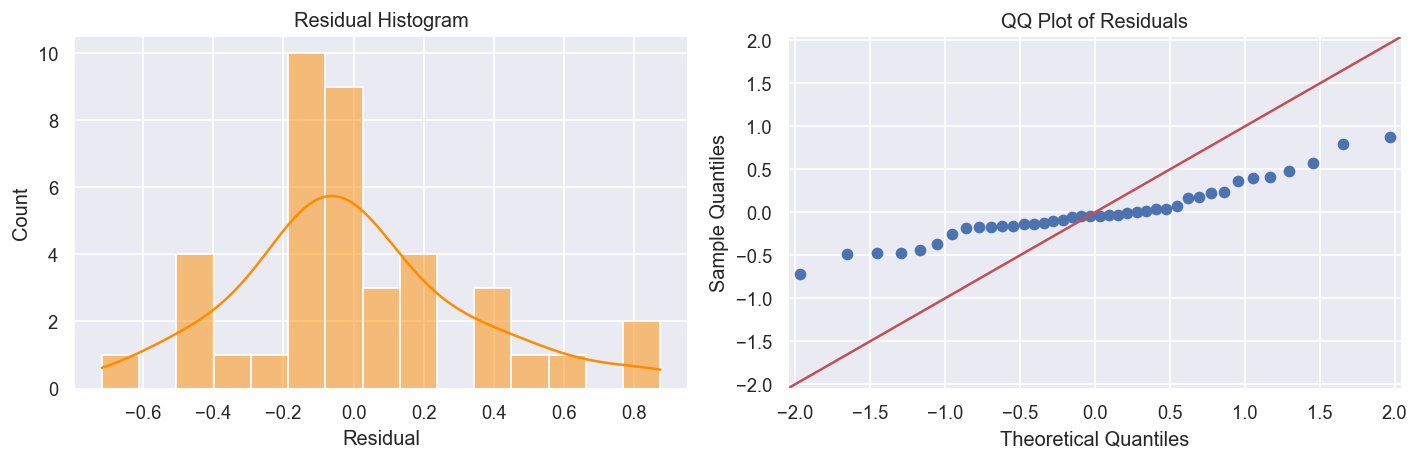

In [15]:
# Normality of Residuals
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Histogram + KDE
sns.histplot(residuals, bins=15, kde=True, ax=ax[0], color='darkorange')
ax[0].set_title('Residual Histogram')
ax[0].set_xlabel('Residual')

# Q-Q Plot
sm.qqplot(residuals, line='45', ax=ax[1])
ax[1].set_title('QQ Plot of Residuals')

plt.tight_layout()
plt.show()

The histogram of residuals illustrates a slightly right skewed distribution. Normality assumption is mildly violated in both tests - this is a mild concern yet it will not hurt prediction accuracy.

### 5.3) Autocorrelation check Durbin–Watson (statsmodels) 

In [16]:
dw = durbin_watson(model2.resid)
print(f"Durbin–Watson: {dw:.3f} (≈2: none, <2: + autocorr, >2: – autocorr | values below 1 & above 3 cause for alarm use)")

Durbin–Watson: 2.412 (≈2: none, <2: + autocorr, >2: – autocorr | values below 1 & above 3 cause for alarm use)


- The Durbin-Watson statistic ranges from 0 to 4: 2 indicates no autocorrelation while values below 1 and above 3 cause for alarm
- Results 2: Indicates no autocorrelation.
- Results 0 to <2: Indicates positive autocorrelation.
- Results >2 to 4: Indicates negative autocorrelation.

The Results are 2.412 meaning there is no autocorrelation.  

### 5.4) Check for multicollinearity (VIF)  

In [17]:
# Create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# make use of the variance_inflation_factor, which will output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
# include names to easily to explore the result
vif["Features"] = X_train_new.columns

display(vif.style.format({"VIF": "{:.3f}"}))

,VIF,Features
0,1.455,population
1,1.332,Coal
2,1.129,Wind


- VIF = 1: no multicollinearity
- 1 < VIF < 5: perfectly okay
- 5 to 10 < VIF: unacceptable

The select variables do not contain any multicollinearity

All assumption have passed with the exception of a slight right skew on normality.

## 6) Evaluation on Test Data

Model Evaluation Summary (Train vs Test):


,Training Set,Testing Set
R²,0.899,0.705
RMSE,0.331,0.466
MAE,0.243,0.413


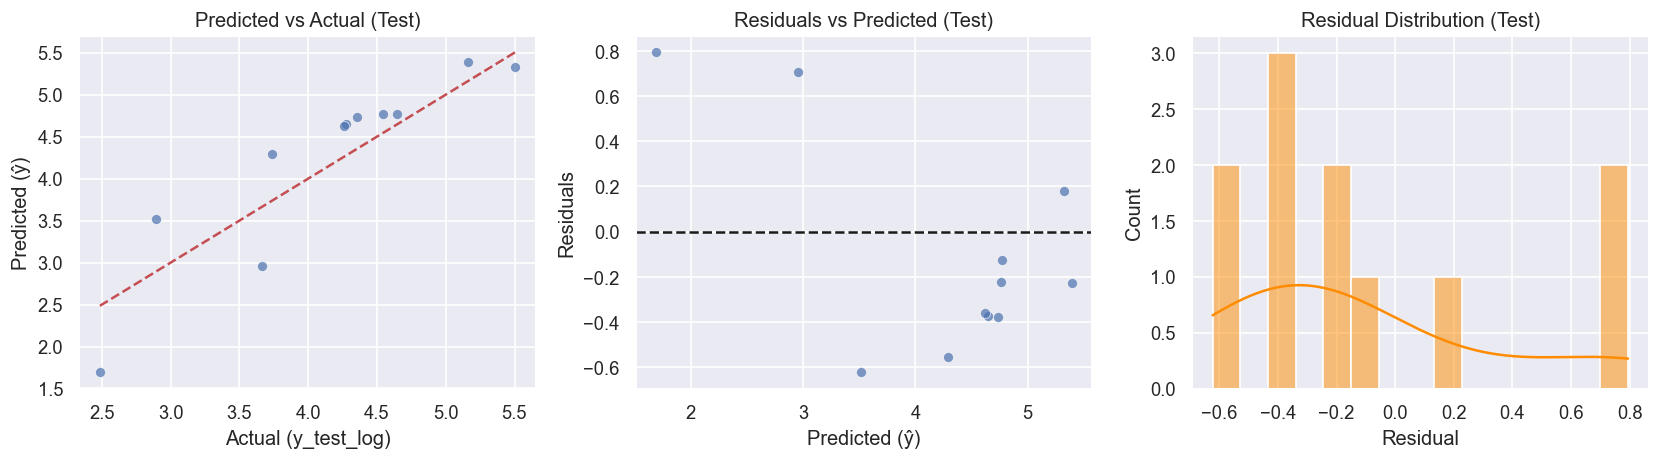

In [20]:
# Predict on TEST data
y_hat_test_log  = reg.predict(X_test_new)

# Evaluate training & testing performance
def model_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return pd.Series({'R²': r2, 'RMSE': rmse, 'MAE': mae})

train_metrics = model_metrics(y_train_log, y_hat_train_log)
test_metrics  = model_metrics(y_test_log,  y_hat_test_log)

# Combine results
summary = pd.concat([train_metrics, test_metrics], axis=1)
summary.columns = ['Training Set', 'Testing Set']
print("Model Evaluation Summary (Train vs Test):")
display(summary.style.format("{:.3f}"))

# Residual diagnostics (test)
residuals = y_test_log - y_hat_test_log

# (1) Predicted vs Actual
fig, axes = plt.subplots(1, 3, figsize=(14,4))
sns.scatterplot(x=y_test_log, y=y_hat_test_log, ax=axes[0], alpha=0.7)
axes[0].plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], 'r--')
axes[0].set_title('Predicted vs Actual (Test)')
axes[0].set_xlabel('Actual (y_test_log)')
axes[0].set_ylabel('Predicted (ŷ)')

# (2) Residuals vs Predicted
sns.scatterplot(x=y_hat_test_log, y=residuals, ax=axes[1], alpha=0.7)
axes[1].axhline(0, color='k', ls='--')
axes[1].set_title('Residuals vs Predicted (Test)')
axes[1].set_xlabel('Predicted (ŷ)')
axes[1].set_ylabel('Residuals')

# (3) Residual Distribution
sns.histplot(residuals, bins=15, kde=True, ax=axes[2], color='darkorange')
axes[2].set_title('Residual Distribution (Test)')
axes[2].set_xlabel('Residual')

plt.tight_layout()
plt.show()


Evaluate generalization with R², RMSE, and MAE on the **test** set, and compare vs **train** to check for over/underfitting.


In [21]:
# Create a DataFrame to manually check the predictions
df_pf = pd.DataFrame(y_hat_test_log, columns=['Prediction'])

# Reset the index as the old indexes are preserved 
y_test_log = y_test_log.reset_index(drop=True)

# Add a 'Target' column with the appropriate values
df_pf['Target'] = y_test_log

# Manually create the Residuals
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

# Manually create the absolute difference in %
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf.head(15)

# Display the result with only 2 digits after the dot
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Sort by difference in % and manually check the model
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
0,4.77,4.64,-0.12,2.68
1,5.32,5.51,0.18,3.28
8,5.39,5.16,-0.23,4.41
7,4.77,4.54,-0.22,4.91
6,4.62,4.26,-0.36,8.45
10,4.73,4.36,-0.38,8.67
4,4.65,4.28,-0.37,8.71
9,4.29,3.74,-0.55,14.82
5,2.95,3.66,0.71,19.35
2,3.51,2.89,-0.62,21.56


## 8) Interpretation & Next Steps

**Model Evaluation Summary Interpretation**

| Metric | Training | Testing | Interpretation |
|:-------|:----------|:---------|:----------------|
| **R²** | 0.899 | 0.705 | The model explains **89.9% of variance** in CO₂ emissions on training data and **70.5%** on unseen data. This is a **strong model** with predictable generalization loss, showing **good fit without severe overfitting**. |
| **RMSE** | 0.331 | 0.466 | The root-mean-squared error increased slightly on the test set, suggesting the model performs consistently, indicating **stable predictive performance**, and is not overfitting. |
| **MAE** | 0.243 | 0.413 | On average, predictions are off by **0.24 log-units** on training and **0.41 log-units** on testing. In log space, this corresponds to ~30–50% error on the original CO₂ scale — very reasonable for macro-level environmental modeling.|

**Overall Interpretation**
This OLS regression model demonstrates **strong explanatory power** and **reasonable generalization** for macro-level emissions:
- The R² drop from 0.899 → 0.705 is expected for real-world data and indicates very mild overfitting.  
- Error metrics **(RMSE/MAE)** remain close between training and testing, confirming **model stability**.  
- The model effectively captures relationships between population and energy consumption variables while maintaining predictive reliability on unseen data.

**Recommendations**
To further improve performance:
1. **Add interaction terms** — e.g., `population_log * Coal_log` or `Gas_log * Nuclear_log` to capture combined effects.  
2. **Adjust appropriate amount of data points contain 0 to mean values** - this would adjust the linearity and normality to be more inline.  
3. **Introduce regional or categorical variables** (e.g., continent, policy type) to account for structural emission differences.

> **In summary:**  
> The model explains most of the variation in CO₂ emissions and performs reliably on new data — this is a strong baseline regression ready for refinement or feature expansion.